# Options Pricing and Delta Hedging: Mathematical Foundations

## Theoretical Background

In financial mathematics, options pricing and hedging strategies are primarily based on the Black-Scholes model, which provides a framework for valuing European-style options. The key assumptions of this model include:

- Constant risk-free interest rate
- No transaction costs
- Continuous trading
- Log-normal distribution of stock prices
- No dividends during the optio -a\ \o10%
- Volatility: 20%
- Initial Stock Price: $1.00
- Strike Price: $0.95

## Mathematical Functions

### 1. Geometric Brownian Motion (GBM) Path Generation
**Theory**: Stock price paths are modeled using a stochastic differential equation

**Stochastic Process**: 
$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

Where:
- $S_t$: Stock price at time $t$
- $\mu$: Drift rate
- $\sigma$: Volatility
- $W_t$: Wiener process (Brownian motion)

**Function Signature**: 
```python
GeneratePathsGBM(NoOfPaths, NoOfSteps, T, r, sigma, S_0)
```

**LaTeX Formula Implementation**:
$$ X_{t+1} = X_t + (r - \frac{1}{2}\sigma^2)dt + \sigma(W_{t+1} - W_t) $$
$$ S_t = \exp(X_t) $$

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import enum

import seaborn as sns


class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0


def GeneratePathsGBM(NoOfPaths, NoOfSteps, T, r, sigma, S_0):
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    time = np.zeros([NoOfSteps + 1])
    X[:, 0] = np.log(S_0)
    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i + 1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]
        X[:, i + 1] = X[:, i] + (r - 0.5 * sigma * sigma) * dt + sigma * (W[:, i + 1] - W[:, i])
        time[i + 1] = time[i] + dt
        S = np.exp(X)
    paths = {"time": time, "S": S}
    return paths

### 2. Black-Scholes Option Pricing
**Theory**: Pricing European options using risk-neutral valuation

**Call Option Price Formula**:
$$ C(S,t) = S_0 \Phi(d_1) - Ke^{-r(T-t)}\Phi(d_2) $$

**Put Option Price Formula**:
$$ P(S,t) = Ke^{-r(T-t)}\Phi(-d_2) - S_0\Phi(-d_1) $$

Where:
- $\Phi(\cdot)$: Cumulative standard normal distribution
- $d_1 = \frac{\ln(S_0/K) + (r + \frac{1}{2}\sigma^2)(T-t)}{\sigma\sqrt{T-t}}$
- $d_2 = d_1 - \sigma\sqrt{T-t}$

In [15]:
def BS_Call_Put_Option_Price(CP, S_0, K, sigma, t, T, r):
    K = np.array(K).reshape([len(K), 1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0))
          * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    if CP == OptionType.CALL:
        value = stats.norm.cdf(d1) * S_0 - stats.norm.cdf(d2) * K * np.exp(-r * (T - t))
    elif CP == OptionType.PUT:
        value = stats.norm.cdf(-d2) * K * np.exp(-r * (T - t)) - stats.norm.cdf(-d1) * S_0
    return value

### 3. Delta Calculation
**Theory**: Sensitivity of option price to underlying asset price changes

**Delta Formula**:
$$ \Delta = \begin{cases} 
\Phi(d_1) & \text{(Call Option)} \\
\Phi(d_1) - 1 & \text{(Put Option)}
\end{cases} $$

In [16]:
def BS_Delta(CP, S_0, K, sigma, t, T, r):
    # when defining a time-grid it may happen that the last grid point
    # is slightly after the maturity
    if t - T > 10e-20 and T - t < 10e-7:
        t = T
    K = np.array(K).reshape([len(K), 1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0)) * \
          (T - t)) / (sigma * np.sqrt(T - t))
    if CP == OptionType.CALL:
        value = stats.norm.cdf(d1)
    elif CP == OptionType.PUT:
        value = stats.norm.cdf(d1) - 1.0
    return value

In [17]:
def enhanced_plotting(time, S, CallM, DeltaM, PnL, path_id=13):
    sns.set(style="darkgrid")

    # Figure 1: Stock, Call Price, Delta, PnL
    plt.figure(figsize=(14, 7))
    plt.plot(time, S[path_id, :], label="Stock Price", color="blue", linewidth=2)
    plt.plot(time, CallM[path_id, :], label="Call Option Price", color="green", linestyle="dashed", linewidth=2)
    plt.plot(time, DeltaM[path_id, :], label="Delta Hedging", color="red", linestyle="dotted", linewidth=2)
    plt.plot(time, PnL[path_id, :], label="PnL", color="purple", linestyle="dashdot", linewidth=2)

    # Mark key buy/sell decisions (example logic)
    buy_sell_points = [i for i in range(1, len(time)) if DeltaM[path_id, i] != DeltaM[path_id, i - 1]]
    plt.scatter([time[i] for i in buy_sell_points], [PnL[path_id, i] for i in buy_sell_points],
                color='black', marker='o', label="Buy/Sell Adjustments", zorder=3)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Zero Profit Line
    plt.xlabel("Time (Years)", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.title("Stock Price, Call Option, Delta Hedging & PnL", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Figure 2: Histogram of P&L
    plt.figure(figsize=(12, 6))
    plt.hist(PnL[:, -1], bins=50, color="skyblue", edgecolor="black", alpha=0.75)
    plt.axvline(0, color='red', linestyle='dashed', linewidth=2, label="Break-even")
    plt.xlim([-0.1, 0.1])
    plt.xlabel("Final PnL", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Distribution of P&L at Expiry", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20048\3859906865.py:7: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0)) * \
C:\Users\lenovo\AppData\Local\Temp\ipykernel_20048\1462663892.py:4: RuntimeWarning: invalid value encountered in sqrt
  * (T - t)) / (sigma * np.sqrt(T - t))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_20048\1462663892.py:5: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T - t)


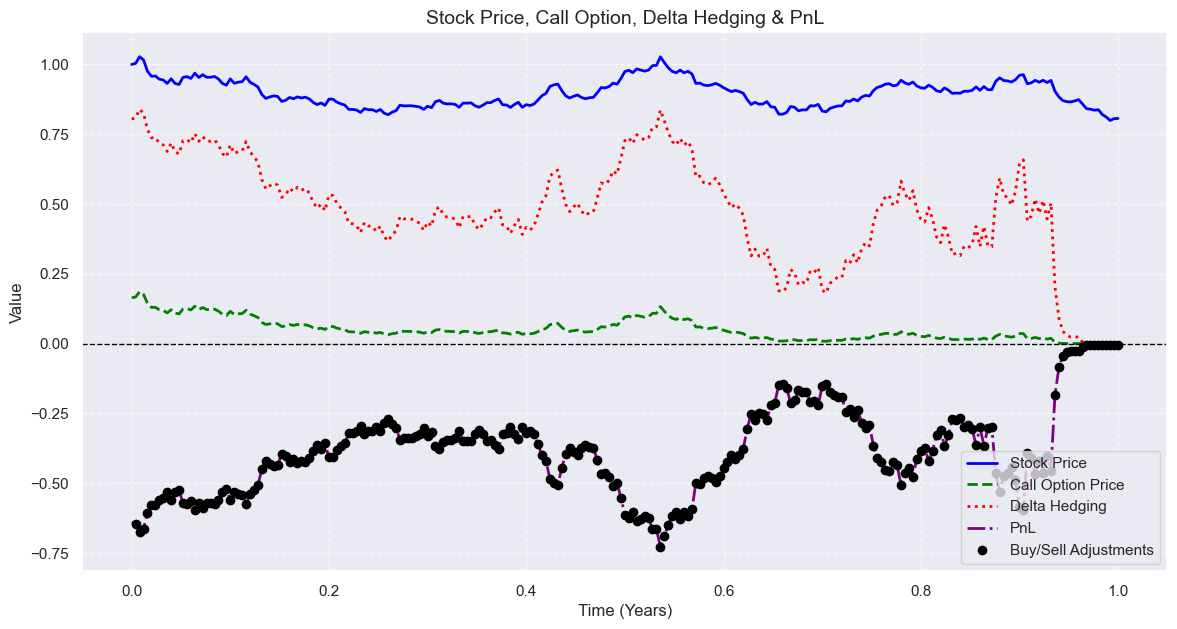

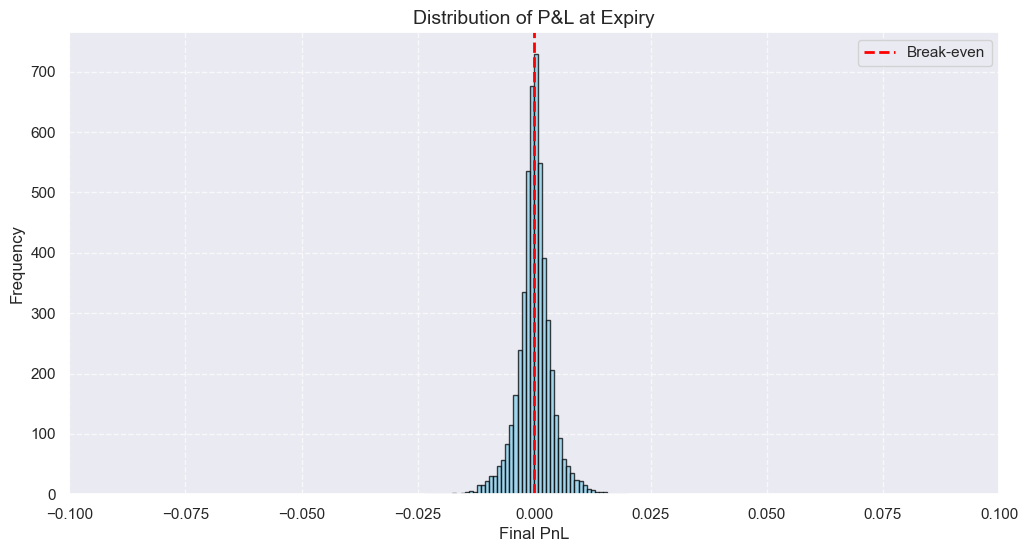

path_id =  0, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9567,S(t_m) = 1.0230, max(S(tm)-K,0)= 0.0730, PnL(t_m) = -0.0071
path_id =  1, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9503,S(t_m) = 1.0460, max(S(tm)-K,0)= 0.0960, PnL(t_m) = -0.0007
path_id =  2, PnL(t_0)=-0.6397, PnL(Tm-1) =0.0000,S(t_m) = 0.7128, max(S(tm)-K,0)= -0.2372, PnL(t_m) = 0.0000
path_id =  3, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9462,S(t_m) = 0.9965, max(S(tm)-K,0)= 0.0465, PnL(t_m) = 0.0032
path_id =  4, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9444,S(t_m) = 1.0305, max(S(tm)-K,0)= 0.0805, PnL(t_m) = 0.0053
path_id =  5, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9500,S(t_m) = 1.0215, max(S(tm)-K,0)= 0.0715, PnL(t_m) = -0.0004
path_id =  6, PnL(t_0)=-0.6397, PnL(Tm-1) =0.0023,S(t_m) = 0.8388, max(S(tm)-K,0)= -0.1112, PnL(t_m) = 0.0023
path_id =  7, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9495,S(t_m) = 1.3834, max(S(tm)-K,0)= 0.4334, PnL(t_m) = 0.0001
path_id =  8, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9483,S(t_m) = 1.3003, max(S(tm)-K,0)= 0.3503, PnL(t_m) = 0.0013
path_id

In [18]:
def mainCalculation():
    NoOfPaths = 5000
    NoOfSteps = 250

    T = 1.0
    r = 0.1
    sigma = 0.2
    s0 = 1.0
    K = [0.95]
    CP = OptionType.CALL
    np.random.seed(2)
    Paths = GeneratePathsGBM(NoOfPaths, NoOfSteps, T, r, sigma, s0)
    time = Paths["time"]
    S = Paths["S"]
    # handy lambda function
    C = lambda t, K, S0: BS_Call_Put_Option_Price(CP, S0, K, sigma, t, T, r)
    Delta = lambda t, K, S0: BS_Delta(CP, S0, K, sigma, t, T, r)

    # setting up inital portfolio
    PnL = np.zeros([NoOfPaths, NoOfSteps + 1])
    delta_init = Delta(0.0, K, s0)
    PnL[:, 0] = C(0.0, K, s0) - delta_init * s0
    CallM = np.zeros([NoOfPaths, NoOfSteps + 1])
    CallM[:, 0] = C(0.0, K, s0)
    DeltaM = np.zeros([NoOfPaths, NoOfSteps + 1])
    DeltaM[:, 0] = Delta(0, K, s0)

    for i in range(1, NoOfSteps + 1):
        dt = time[i] - time[i - 1]
        delta_old = Delta(time[i - 1], K, S[:, i - 1])
        delta_curr = Delta(time[i], K, S[:, i])

        PnL[:, i] = PnL[:, i - 1] * np.exp(r * dt) - (delta_curr - delta_old) * S[:, i]
        CallM[:, i] = C(time[i], K, S[:, i])
        DeltaM[:, i] = delta_curr
        # final payment of in the money option
    PnL[:, -1] = PnL[:, -1] - np.maximum(S[:, -1] - K, 0) + DeltaM[:, -1] * S[:, -1]

    path_id = 13
    enhanced_plotting(time, S, CallM, DeltaM, PnL, path_id)

    # Analysis for each path
    for i in range(0, NoOfPaths):
        print(

            'path_id = {0:2d}, PnL(t_0)={1:0.4f}, PnL(Tm-1) ={2:0.4f},S(t_m) = {3:0.4f}, max(S(tm)-K,0)= {4:0.4f}, PnL(t_m) = {5:0.4f}'.format(
                i, PnL[0, 0],

                PnL[i, -2], S[i, -1], np.max(S[i, -1] - K, 0), PnL[i, -1]))


mainCalculation()

### 4. Profit and Loss (PnL) Calculation
**Continuous Hedging Strategy**:
$$ \text{PnL}_{t+1} = \text{PnL}_t e^{r\Delta t} - (\Delta_{t+1} - \Delta_t)S_{t+1} $$

## Simulation Methodology
- Generate multiple stock price paths
- Calculate option prices and deltas at each time step
- Dynamically hedge to minimize portfolio risk
- Analyze distribution of final profits and losses


### Key Simulation Parameters
- Paths: 5000
- Time Steps: 250
- Time to Maturity: 1 year
- Risk-free Rate: 10%
- Volatility: 20%
- Initial Stock Price: $1.00
- Strike Price: $0.95